In [2]:
import pandas as pd
import os
import numpy as np

import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

## Filling gaps in filtered datasets

### Gap filling methods validation 

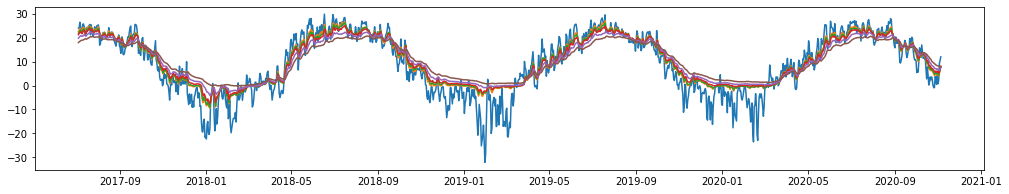

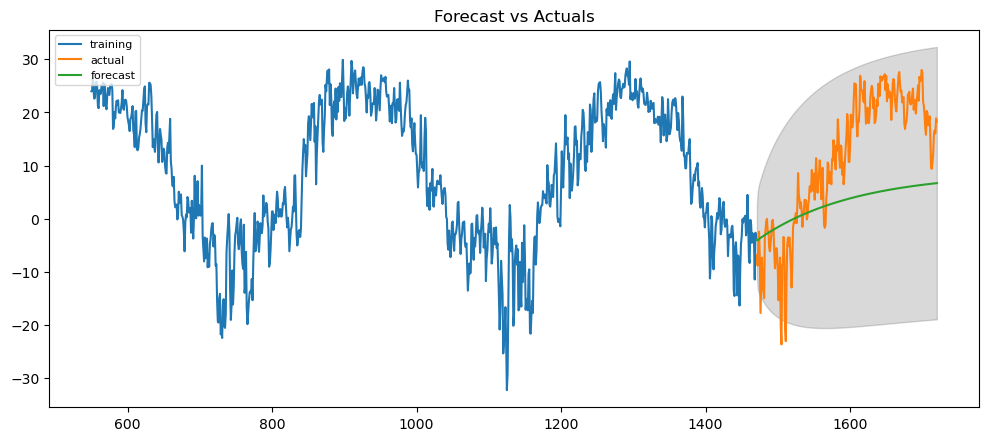

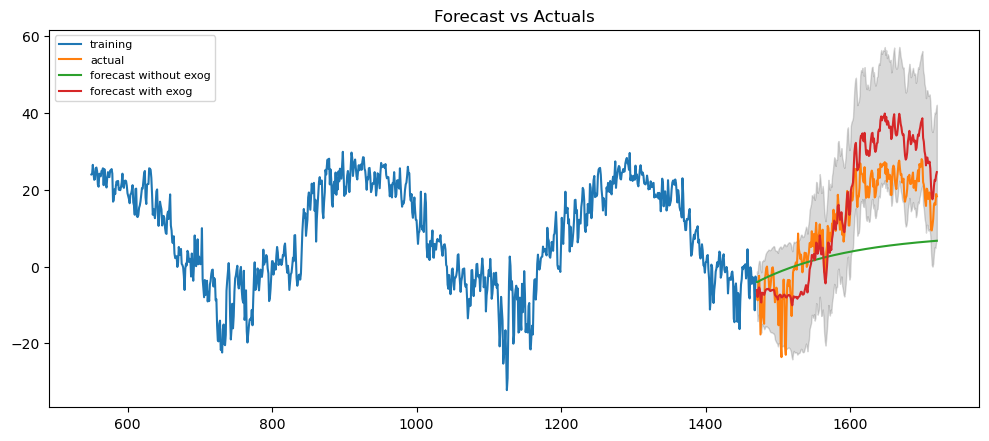

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'
test_file='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/parsed_by_station_data/WI_Necedah_5_WNW.txt'
df=pd.read_csv(test_file, sep=' ', header=None)
df[1] = pd.to_datetime(df[1], format='%Y%m%d')
filtered_df={'LST_DATE':df[1][550:],
            'SUR_TEMP_DAILY_AVG':df[14][550:],
            'SOIL_TEMP_5_DAILY':df[23][550:],
            'SOIL_TEMP_10_DAILY':df[24][550:],
            'SOIL_TEMP_20_DAILY':df[25][550:],
            'SOIL_TEMP_50_DAILY':df[26][550:],
            'SOIL_TEMP_100_DAILY':df[27][550:]}
filtered_df = pd.DataFrame(filtered_df, columns = ['LST_DATE', 'SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY', 
                                                     'SOIL_TEMP_10_DAILY', 'SOIL_TEMP_20_DAILY', 
                                                     'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'])
plt.rcParams['figure.figsize'] = [17, 3]
plt.plot(filtered_df['LST_DATE'], filtered_df['SUR_TEMP_DAILY_AVG'], label='SUR_TEMP_DAILY_AVG')
plt.plot(filtered_df['LST_DATE'], filtered_df['SOIL_TEMP_5_DAILY'], label='SOIL_TEMP_5_DAILY')
plt.plot(filtered_df['LST_DATE'], filtered_df['SOIL_TEMP_10_DAILY'], label='SOIL_TEMP_10_DAILY')
plt.plot(filtered_df['LST_DATE'], filtered_df['SOIL_TEMP_20_DAILY'], label='SOIL_TEMP_20_DAILY')
plt.plot(filtered_df['LST_DATE'], filtered_df['SOIL_TEMP_50_DAILY'], label='SOIL_TEMP_50_DAILY')
plt.plot(filtered_df['LST_DATE'], filtered_df['SOIL_TEMP_100_DAILY'], label='SOIL_TEMP_100_DAILY')
plt.show()


test_size=300
train, test = filtered_df[['SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY']][:-test_size], filtered_df[['SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY']][-test_size:]

fitted_model = ARIMA(train['SUR_TEMP_DAILY_AVG'], order=(3,0,1)).fit(disp=0)

fc_size=250
fc, se, conf = fitted_model.forecast(fc_size, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test.index[0:fc_size])
lower_series = pd.Series(conf[:, 0], index=test.index[0:fc_size])
upper_series = pd.Series(conf[:, 1], index=test.index[0:fc_size])

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['SUR_TEMP_DAILY_AVG'], label='training')
plt.plot(test['SUR_TEMP_DAILY_AVG'][0:fc_size], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##############
fitted_model_exog = ARIMA(train['SUR_TEMP_DAILY_AVG'], order=(3,0,1), exog=train['SOIL_TEMP_5_DAILY']).fit(disp=0)

fc_size=250
fc_exog, se, conf = fitted_model_exog.forecast(fc_size, alpha=0.05, exog=test['SOIL_TEMP_5_DAILY'][0:fc_size])

fc_series = pd.Series(fc, index=test.index[0:fc_size])
fc_exog_series = pd.Series(fc_exog, index=test.index[0:fc_size])
lower_series = pd.Series(conf[:, 0], index=test.index[0:fc_size])
upper_series = pd.Series(conf[:, 1], index=test.index[0:fc_size])

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['SUR_TEMP_DAILY_AVG'], label='training')
plt.plot(test['SUR_TEMP_DAILY_AVG'][0:fc_size], label='actual')
plt.plot(fc_series, label='forecast without exog')
plt.plot(fc_exog_series, label='forecast with exog')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [4]:
from sklearn import linear_model

def fill_gaps_linear(input_array, nodata, window_size=100, dead_recursion=False, max_gap_size=5):    
    reverse_mode=False
    output_array = np.copy(input_array)
    gaps_indeces=(np.array(np.where(output_array==nodata))[0]).tolist()
    gap_size=0
    gaps_list=[]
    for index in gaps_indeces:
        gaps_list.append(index)
        gap_size+=1
        if index+1 not in gaps_indeces:
            if gap_size>max_gap_size:               
                for gap in gaps_list:
                    gaps_indeces.remove(gap)     
            
            gaps_list=[]
            gap_size=0     
    for index in gaps_indeces:
        if index<window_size*2:
            reverse_mode=True
        if index>window_size*2 and len(np.argwhere(output_array[index-window_size*2:index]==nodata))>0:
            reverse_mode=True
        if index>window_size*2 and len(np.argwhere(output_array[index-window_size*2:index]==nodata))==0:
            x_train=[]
            y_train=[]
            pre_set=output_array[index-window_size*2:index]
            for i in range(window_size):
                y=pre_set[window_size*2-i-1]
                y_train.append(y)
                x=pre_set[window_size*2-i-3:window_size*2-i-1]
                x_train.append(x.tolist())
            sample_predictors=output_array[index-2:index]
            regr = linear_model.LinearRegression()
            regr.fit(x_train, y_train)
            y_pred = regr.predict([sample_predictors])            
            output_array[index]=y_pred[0]
    if reverse_mode==True and dead_recursion==False:
        reversed_input=np.fliplr([np.array(output_array)])[0]
        output_array=fill_gaps_linear(reversed_input,  nodata, window_size=window_size*1, dead_recursion=True)
        output_array=np.fliplr([np.array(output_array)])[0]
    return output_array

def fill_gaps_arima(input_array, exog_variables_list, nodata):
    output_array = np.copy(input_array)
    gaps_indeces=(np.array(np.where(output_array==nodata))[0]).tolist()
    gaps_list=[]
    for index in gaps_indeces:
        gaps_list.append(index)
        if index+1 not in gaps_indeces:
            fc_size=len(gaps_list)
            train=output_array[:gaps_list[0]]
            for variable in exog_variables_list:
                exog_train=variable[:gaps_list[0]]
                exog_test=variable[gaps_list[0]:gaps_list[-1]+1]
                if (np.array(np.where(exog_train==nodata))).shape[1]==0 and (np.array(np.where(exog_test==nodata))).shape[1]==0:
                    break
                else:
                    exog_train=[]
                    exog_test=[]
            
            if len(exog_train)!=0:
                print('Exog mode')
                fitted_model_exog = ARIMA(train, order=(3,0,1), exog=exog_train).fit(disp=0)
                fc_exog, se, conf = fitted_model_exog.forecast(fc_size, alpha=0.05, exog=exog_test)                
                output_array[gaps_list[0]:gaps_list[-1]+1]=fc_exog
            if len(exog_train)==0:
                print('Not Exog mode')
                fitted_model_exog = ARIMA(train, order=(3,0,1)).fit(disp=0)
                fc_exog, se, conf = fitted_model_exog.forecast(fc_size, alpha=0.05)                
                output_array[gaps_list[0]:gaps_list[-1]+1]=fc_exog
            break
    return output_array

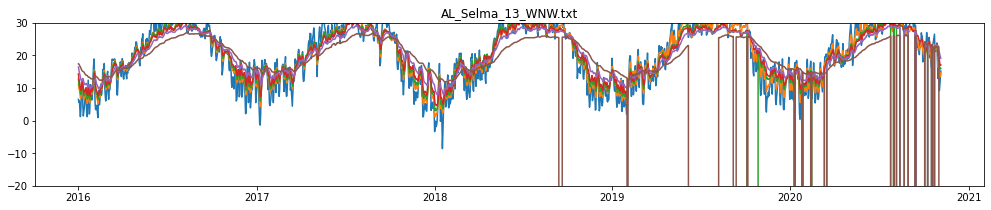

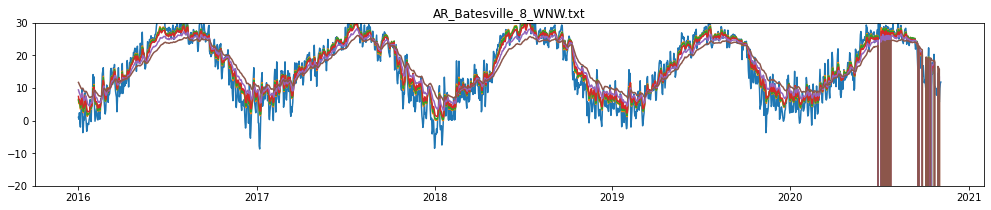

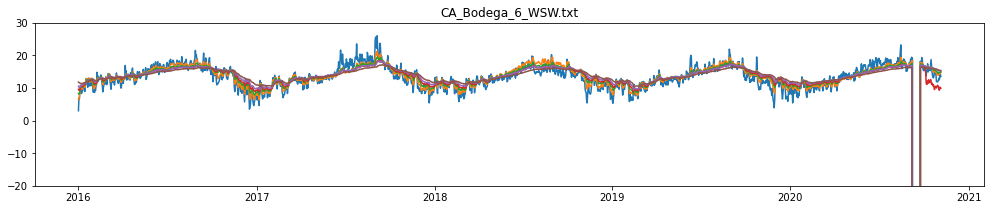

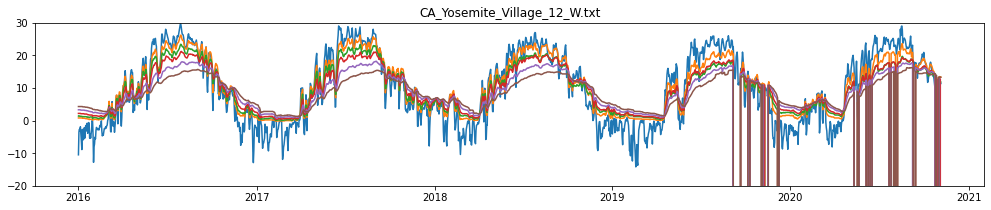

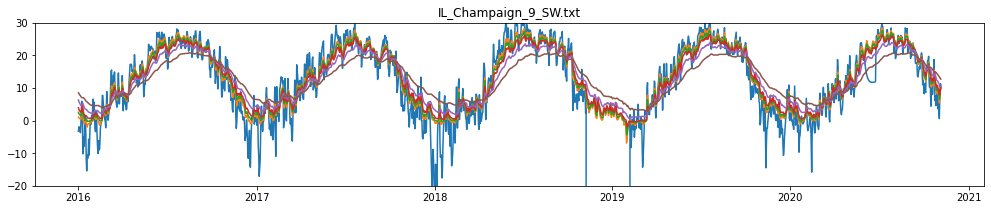

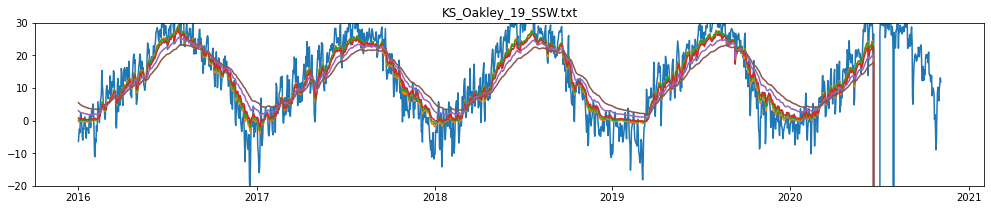

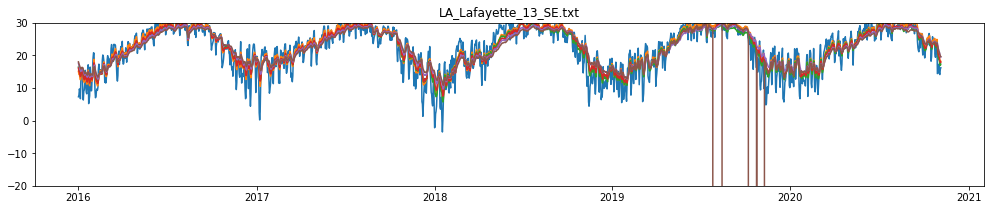

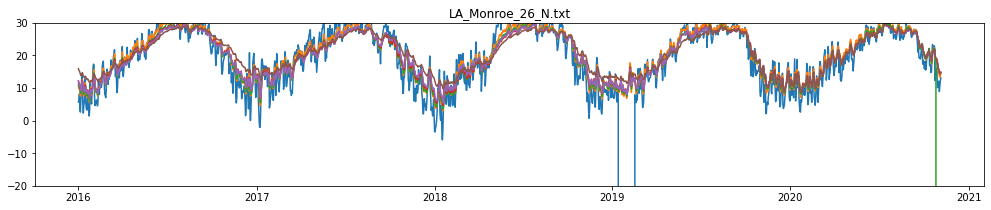

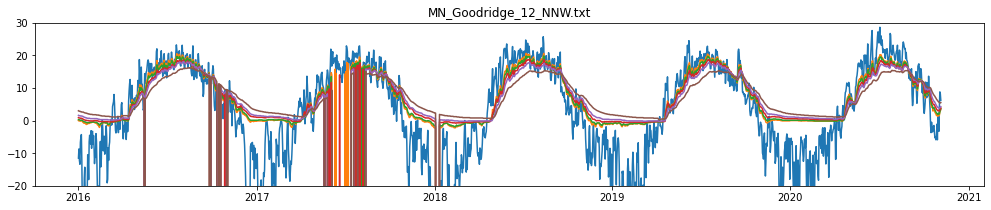

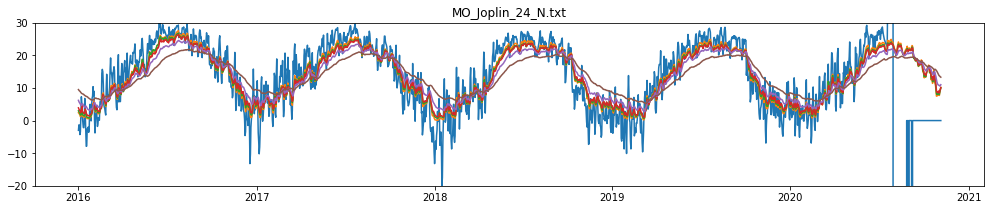

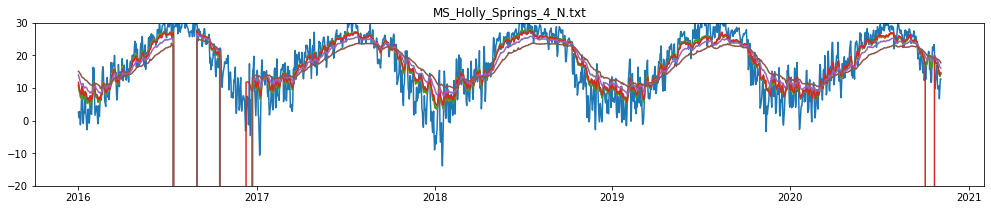

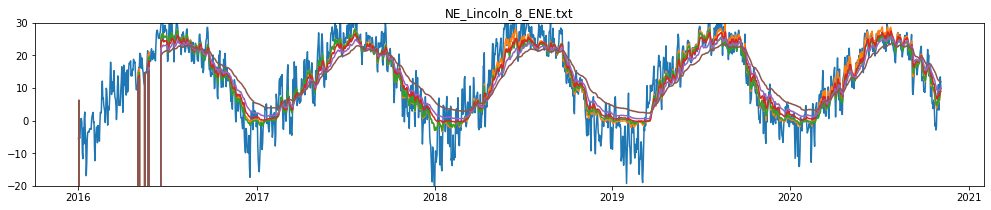

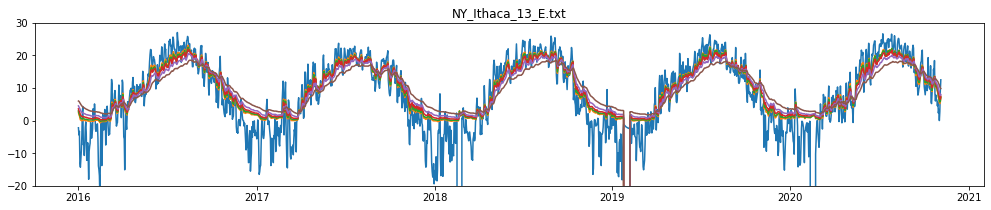

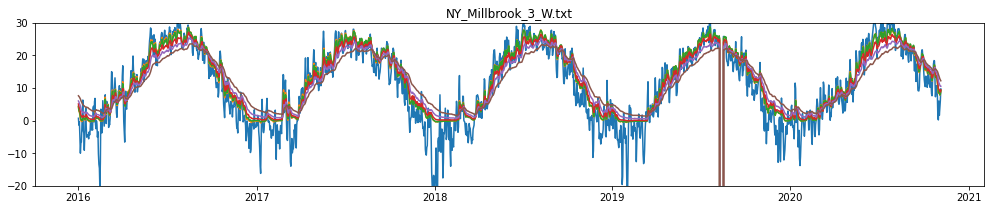

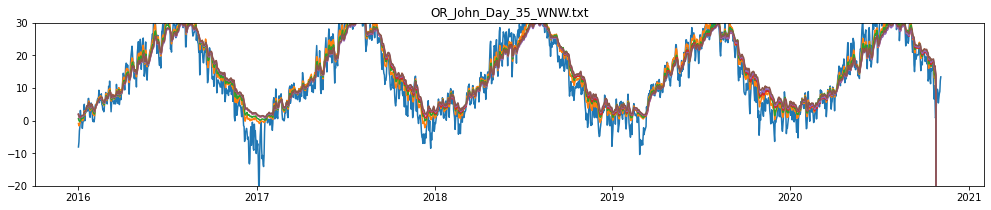

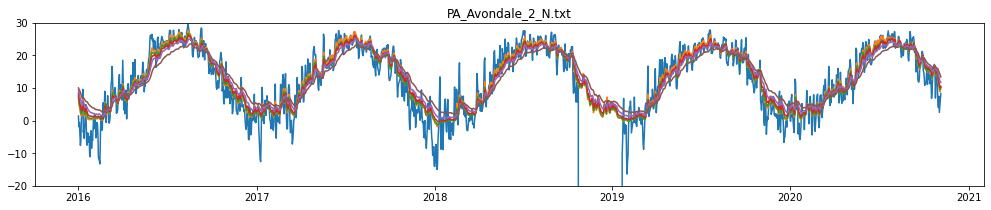

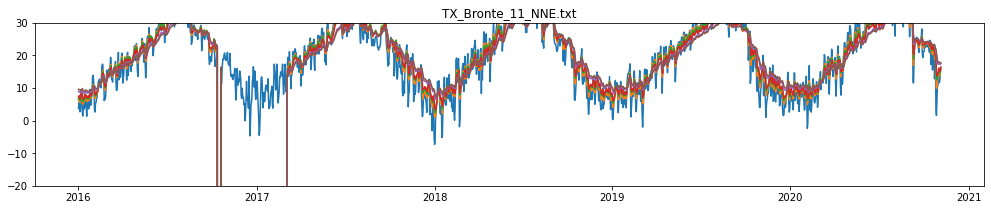

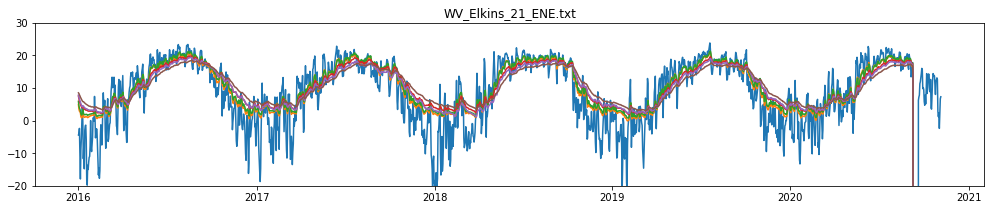

['AL_Selma_13_WNW.txt', 'AR_Batesville_8_WNW.txt', 'CA_Bodega_6_WSW.txt', 'CA_Yosemite_Village_12_W.txt', 'IL_Champaign_9_SW.txt', 'KS_Oakley_19_SSW.txt', 'LA_Lafayette_13_SE.txt', 'LA_Monroe_26_N.txt', 'MN_Goodridge_12_NNW.txt', 'MO_Joplin_24_N.txt', 'MS_Holly_Springs_4_N.txt', 'NE_Lincoln_8_ENE.txt', 'NY_Ithaca_13_E.txt', 'NY_Millbrook_3_W.txt', 'OR_John_Day_35_WNW.txt', 'PA_Avondale_2_N.txt', 'TX_Bronte_11_NNE.txt', 'WV_Elkins_21_ENE.txt']


In [6]:
plt.rcParams['figure.figsize'] = [17, 3]
parsed_data_folder='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/parsed_by_station_data'
no_gaps_folder='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/no_gaps_data'
list_with_large_gaps=[]
for file in os.listdir(parsed_data_folder):
    df=pd.read_csv(os.path.join(parsed_data_folder, file), sep=' ', header=None)
    df[1] = pd.to_datetime(df[1], format='%Y%m%d')

    # filling gaps with size less than 5

    l_SURF=fill_gaps_linear(df[14], -9999)
    l_5=fill_gaps_linear(df[23], -9999)
    l_10=fill_gaps_linear(df[24], -9999)
    l_20=fill_gaps_linear(df[25], -9999)
    l_50=fill_gaps_linear(df[26], -9999)
    l_100=fill_gaps_linear(df[27], -9999)
    
    # saving stations with successful linear-regression 
    
    if (np.array(np.where(np.array(l_SURF)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_5)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_10)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_20)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_50)==-9999))).shape[1]==0 and (np.array(np.where(np.array(l_100)==-9999))).shape[1]==0:   
        data={'LST_DATE':df[1],
                'SUR_TEMP_DAILY_AVG':l_SURF,
                'SOIL_TEMP_5_DAILY':l_5,
                'SOIL_TEMP_10_DAILY':l_10,
                'SOIL_TEMP_20_DAILY':l_20,
                'SOIL_TEMP_50_DAILY':l_50,
                'SOIL_TEMP_100_DAILY':l_100}
        no_gaps_df = pd.DataFrame(data, columns = ['LST_DATE', 'SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY',
                                                   'SOIL_TEMP_20_DAILY', 'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'])
        #no_gaps_df.to_csv(os.path.join(no_gaps_folder, file), index=False)
    else:
        list_with_large_gaps.append(file)
        plt.plot(df[1], l_SURF)
        plt.plot(df[1], l_5)
        plt.plot(df[1], l_10)
        plt.plot(df[1], l_20)
        plt.plot(df[1], l_50)
        plt.plot(df[1], l_100)

        plt.title(file)
        plt.ylim(-20, 30)
        plt.show()
        
print(list_with_large_gaps)

Not Exog mode
Exog mode
Exog mode
Exog mode
Exog mode


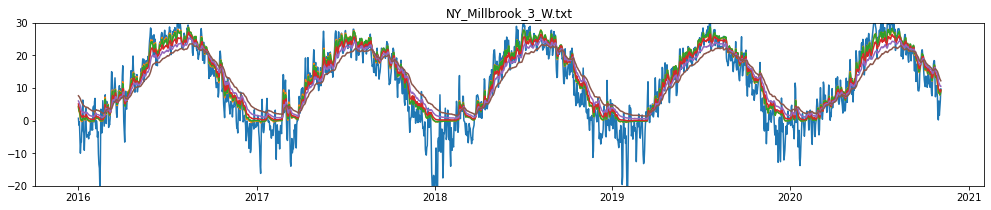

In [8]:
s=['NY_Millbrook_3_W.txt']

for file in s:
    df=pd.read_csv(os.path.join(parsed_data_folder, file), sep=' ', header=None)
    df[1] = pd.to_datetime(df[1], format='%Y%m%d')
    
    l_SURF=fill_gaps_linear(df[14], -9999)
    l_5=fill_gaps_linear(df[23], -9999)
    l_10=fill_gaps_linear(df[24], -9999)
    l_20=fill_gaps_linear(df[25], -9999)
    l_50=fill_gaps_linear(df[26], -9999)
    l_100=fill_gaps_linear(df[27], -9999)
    
    l_100=fill_gaps_linear(l_100, -9999, max_gap_size=50)
    try:
        while (np.array(np.where(np.array(l_SURF)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_5)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_10)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_20)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_50)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_100)==-9999))).shape[1]!=0:
            l_SURF=fill_gaps_arima(l_SURF, [l_5, l_10, l_20, l_50, l_SURF], -9999)
            l_5=fill_gaps_arima(l_5, [l_10, l_20, l_50, l_100, l_SURF], -9999)
            l_10=fill_gaps_arima(l_10, [l_5, l_20, l_50, l_100, l_SURF], -9999)
            l_20=fill_gaps_arima(l_20, [l_5, l_10, l_50, l_100, l_SURF], -9999)
            l_50=fill_gaps_arima(l_50, [l_20, l_10, l_100, l_5, l_SURF], -9999)
            #l_100=fill_gaps_arima(l_100, [l_50, l_20, l_10, l_5, l_SURF], -9999)
    except Exception:
        pass
    
    data={'LST_DATE':df[1],
                'SUR_TEMP_DAILY_AVG':l_SURF,
                'SOIL_TEMP_5_DAILY':l_5,
                'SOIL_TEMP_10_DAILY':l_10,
                'SOIL_TEMP_20_DAILY':l_20,
                'SOIL_TEMP_50_DAILY':l_50,
                'SOIL_TEMP_100_DAILY':l_100}
    no_gaps_df = pd.DataFrame(data, columns = ['LST_DATE', 'SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY',
                                               'SOIL_TEMP_20_DAILY', 'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'])
    #no_gaps_df.to_csv(os.path.join(no_gaps_folder, file), index=False)
        
    plt.plot(df[1], l_SURF)
    plt.plot(df[1], l_5)
    plt.plot(df[1], l_10)
    plt.plot(df[1], l_20)
    plt.plot(df[1], l_50)
    plt.plot(df[1], l_100)

    plt.title(file)
    plt.ylim(-20, 30)
    plt.show()

Exog mode
Exog mode
Exog mode
Exog mode
Exog mode


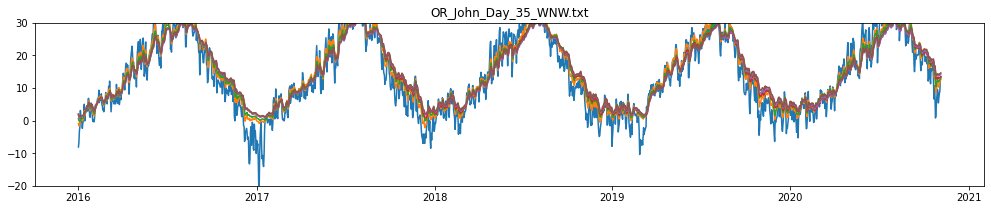

Exog mode
Exog mode
Exog mode
Exog mode
Exog mode
Exog mode
Exog mode


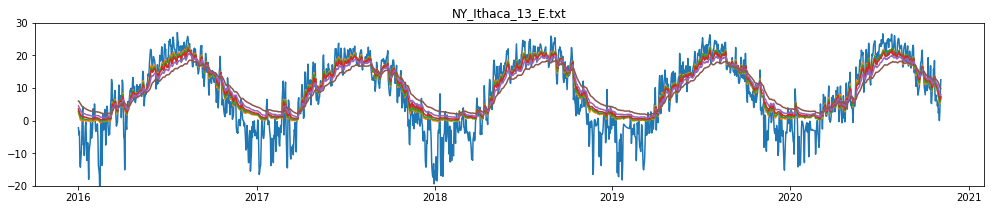

Exog mode
Exog mode
Exog mode


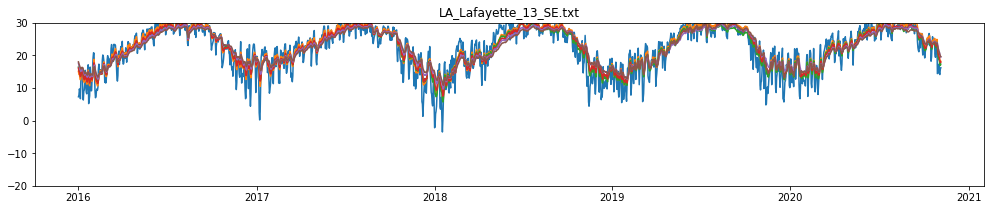

Exog mode
Exog mode


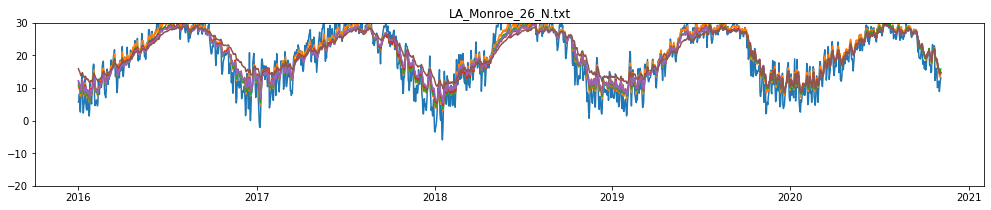

Not Exog mode
Exog mode
Exog mode
Exog mode


C:\Users\Julia\.conda\envs\geoenv3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Julia\.conda\envs\geoenv3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Exog mode
Exog mode


C:\Users\Julia\.conda\envs\geoenv3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Julia\.conda\envs\geoenv3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


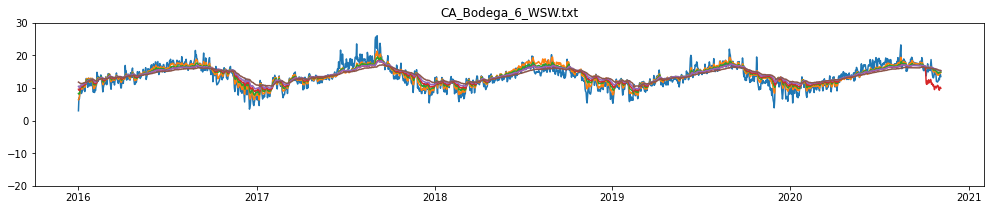

In [9]:
list_for_arima=['OR_John_Day_35_WNW.txt','NY_Ithaca_13_E.txt', 'LA_Lafayette_13_SE.txt', 
                'LA_Monroe_26_N.txt', 'CA_Bodega_6_WSW.txt']

for file in list_for_arima:
    df=pd.read_csv(os.path.join(parsed_data_folder, file), sep=' ', header=None)
    df[1] = pd.to_datetime(df[1], format='%Y%m%d')
    
    l_SURF=fill_gaps_linear(df[14], -9999)
    l_5=fill_gaps_linear(df[23], -9999)
    l_10=fill_gaps_linear(df[24], -9999)
    l_20=fill_gaps_linear(df[25], -9999)
    l_50=fill_gaps_linear(df[26], -9999)
    l_100=fill_gaps_linear(df[27], -9999)
    
    try:
        while (np.array(np.where(np.array(l_SURF)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_5)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_10)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_20)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_50)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_100)==-9999))).shape[1]!=0:
            l_SURF=fill_gaps_arima(l_SURF, [l_5, l_10, l_20, l_50, l_SURF], -9999)
            l_5=fill_gaps_arima(l_5, [l_10, l_20, l_50, l_100, l_SURF], -9999)
            l_10=fill_gaps_arima(l_10, [l_5, l_20, l_50, l_100, l_SURF], -9999)
            l_20=fill_gaps_arima(l_20, [l_5, l_10, l_50, l_100, l_SURF], -9999)
            l_50=fill_gaps_arima(l_50, [l_20, l_10, l_100, l_5, l_SURF], -9999)
            l_100=fill_gaps_arima(l_100, [l_50, l_20, l_10, l_5, l_SURF], -9999)
    except Exception:
        pass
    
    data={'LST_DATE':df[1],
                'SUR_TEMP_DAILY_AVG':l_SURF,
                'SOIL_TEMP_5_DAILY':l_5,
                'SOIL_TEMP_10_DAILY':l_10,
                'SOIL_TEMP_20_DAILY':l_20,
                'SOIL_TEMP_50_DAILY':l_50,
                'SOIL_TEMP_100_DAILY':l_100}
    no_gaps_df = pd.DataFrame(data, columns = ['LST_DATE', 'SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY',
                                               'SOIL_TEMP_20_DAILY', 'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'])
    #no_gaps_df.to_csv(os.path.join(no_gaps_folder, file), index=False)
        
    plt.plot(df[1], l_SURF)
    plt.plot(df[1], l_5)
    plt.plot(df[1], l_10)
    plt.plot(df[1], l_20)
    plt.plot(df[1], l_50)
    plt.plot(df[1], l_100)

    plt.title(file)
    plt.ylim(-20, 30)
    plt.show()

Exog mode


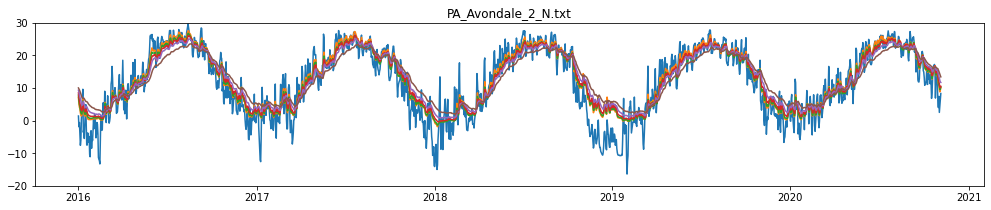

Not Exog mode
Exog mode
Exog mode
Exog mode
Exog mode
Exog mode


C:\Users\Julia\.conda\envs\geoenv3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Exog mode
Exog mode
Exog mode
Exog mode
Exog mode


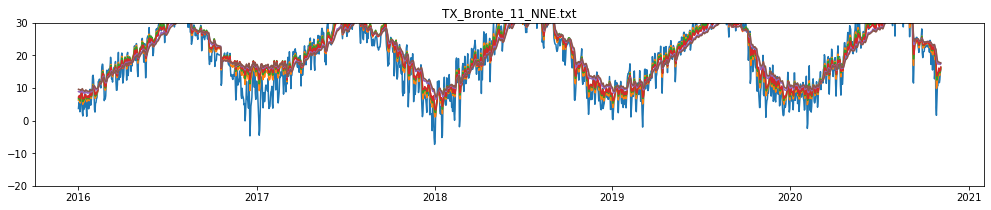

Exog mode


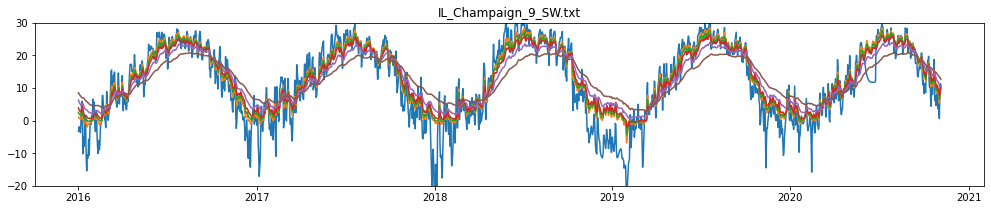

In [10]:
list_for_arima=['PA_Avondale_2_N.txt', 'TX_Bronte_11_NNE.txt', 'IL_Champaign_9_SW.txt']
for file in list_for_arima:
    df=pd.read_csv(os.path.join(parsed_data_folder, file), sep=' ', header=None)
    df[1] = pd.to_datetime(df[1], format='%Y%m%d')
    
    l_SURF=fill_gaps_linear(df[14], -9999)
    l_5=fill_gaps_linear(df[23], -9999)
    l_10=fill_gaps_linear(df[24], -9999)
    l_20=fill_gaps_linear(df[25], -9999)
    l_50=fill_gaps_linear(df[26], -9999)
    l_100=fill_gaps_linear(df[27], -9999)
    
    try:
        while (np.array(np.where(np.array(l_SURF)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_5)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_10)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_20)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_50)==-9999))).shape[1]!=0 or (np.array(np.where(np.array(l_100)==-9999))).shape[1]!=0:
            l_SURF=fill_gaps_arima(l_SURF, [l_5, l_10, l_20, l_50, l_100], -9999)
            l_5=fill_gaps_arima(l_5, [l_10, l_20, l_50, l_100, l_SURF], -9999)
            l_10=fill_gaps_arima(l_10, [l_5, l_20, l_50, l_100, l_SURF], -9999)
            l_20=fill_gaps_arima(l_20, [l_5, l_10, l_50, l_100, l_SURF], -9999)
            l_50=fill_gaps_arima(l_50, [l_20, l_10, l_100, l_5, l_SURF], -9999)
            l_100=fill_gaps_arima(l_100, [l_50, l_20, l_10, l_5, l_SURF], -9999)
    except Exception:
        pass
    
    data={'LST_DATE':df[1],
                'SUR_TEMP_DAILY_AVG':l_SURF,
                'SOIL_TEMP_5_DAILY':l_5,
                'SOIL_TEMP_10_DAILY':l_10,
                'SOIL_TEMP_20_DAILY':l_20,
                'SOIL_TEMP_50_DAILY':l_50,
                'SOIL_TEMP_100_DAILY':l_100}
    no_gaps_df = pd.DataFrame(data, columns = ['LST_DATE', 'SUR_TEMP_DAILY_AVG', 'SOIL_TEMP_5_DAILY', 'SOIL_TEMP_10_DAILY',
                                               'SOIL_TEMP_20_DAILY', 'SOIL_TEMP_50_DAILY', 'SOIL_TEMP_100_DAILY'])
    #no_gaps_df.to_csv(os.path.join(no_gaps_folder, file), index=False)
        
    plt.plot(df[1], l_SURF)
    plt.plot(df[1], l_5)
    plt.plot(df[1], l_10)
    plt.plot(df[1], l_20)
    plt.plot(df[1], l_50)
    plt.plot(df[1], l_100)

    plt.title(file)
    plt.ylim(-20, 30)
    plt.show()